<a href="https://colab.research.google.com/github/Hariniii44/Malaria-detection/blob/main/Malaria_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import tensorflow as tf
import os

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [10]:
!pip install -q kaggle

# Creating a kaggle directory
!mkdir -p ~/.kaggle

from google.colab import files

print("Please upload your kaggle.json file:")
uploaded = files.upload()

!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("\n Kaggle API configured!")

Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json

 Kaggle API configured!


In [11]:
# Download dataset from Kaggle
print("Downloading malaria dataset from Kaggle...")
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

print("\n Extracting dataset...")
!unzip -q cell-images-for-detecting-malaria.zip

print("\n Dataset ready!")

# Verify
import os

if os.path.exists('cell_images'):
    para_count = len(os.listdir('cell_images/Parasitized'))
    uninf_count = len(os.listdir('cell_images/Uninfected'))

    print(f"\n Dataset Statistics:")
    print(f"  • Parasitized: {para_count:,} images")
    print(f"  • Uninfected: {uninf_count:,} images")
    print(f"  • Total: {para_count + uninf_count:,} images")
else:
    print("Error: cell_images folder not found")

Dataset URL: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria
License(s): unknown
 99% 667M/675M [00:01<00:00, 271MB/s]
100% 675M/675M [00:01<00:00, 375MB/s]

 Extracting dataset...

 Dataset ready!

 Dataset Statistics:
  • Parasitized: 13,780 images
  • Uninfected: 13,780 images
  • Total: 27,560 images


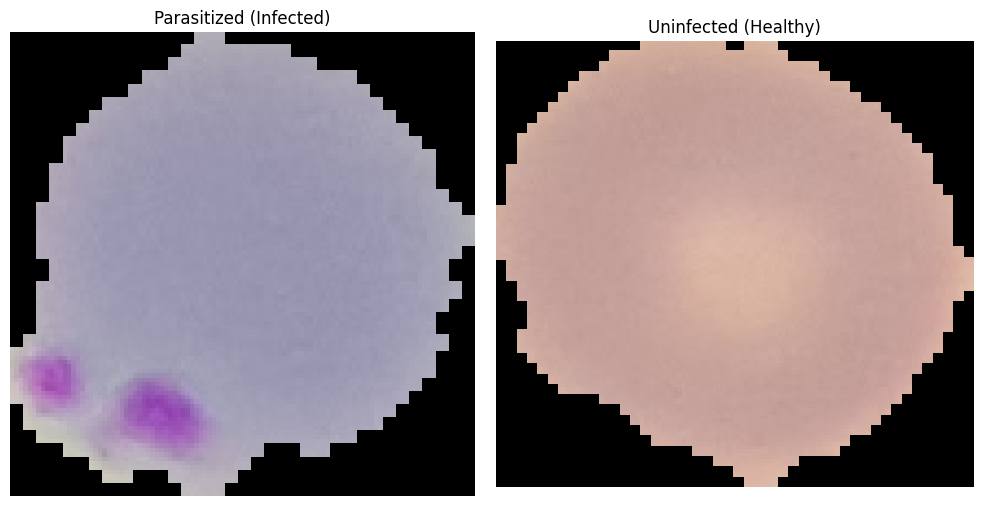

Dataset loaded and verified!


In [12]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load one sample from each class
para_path = 'cell_images/Parasitized/' + os.listdir('cell_images/Parasitized')[0]
uninf_path = 'cell_images/Uninfected/' + os.listdir('cell_images/Uninfected')[0]

para_img = Image.open(para_path)
uninf_img = Image.open(uninf_path)

# Display
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(para_img)
axes[0].set_title('Parasitized (Infected)', fontsize=12)
axes[0].axis('off')

axes[1].imshow(uninf_img)
axes[1].set_title('Uninfected (Healthy)', fontsize=12)
axes[1].axis('off')

plt.tight_layout()
plt.show()

print("Dataset loaded and verified!")

In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    roc_auc_score
)

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("=" * 70)
print("LIBRARIES IMPORTED SUCCESSFULLY")
print("=" * 70)
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU'))} GPU(s)")
print("=" * 70)

LIBRARIES IMPORTED SUCCESSFULLY
TensorFlow version: 2.19.0
Keras version: 3.10.0
GPU Available: 1 GPU(s)


In [14]:
# Check current directory and files
print("Current directory:", os.getcwd())
print("\nFiles in current directory:")
!ls -la

print("\n" + "="*70)
print("Checking for cell_images folder:")
if os.path.exists('cell_images'):
    print("✓ cell_images folder EXISTS")
    print("\nContents of cell_images:")
    !ls -la cell_images/
else:
    print("❌ cell_images folder NOT FOUND")

print("\n" + "="*70)
print("Let's see ALL files/folders here:")
!ls -la

Current directory: /content

Files in current directory:
total 691604
drwxr-xr-x 1 root root      4096 Dec 29 20:23 .
drwxr-xr-x 1 root root      4096 Dec 29 20:11 ..
drwxr-xr-x 5 root root      4096 Dec 29 20:23 cell_images
-rw-r--r-- 1 root root 708172590 Oct 14  2019 cell-images-for-detecting-malaria.zip
drwxr-xr-x 4 root root      4096 Dec  9 14:41 .config
-rw-r--r-- 1 root root        67 Dec 29 20:23 kaggle.json
drwxr-xr-x 1 root root      4096 Dec  9 14:42 sample_data

Checking for cell_images folder:
✓ cell_images folder EXISTS

Contents of cell_images:
total 2136
drwxr-xr-x 5 root root    4096 Dec 29 20:23 .
drwxr-xr-x 1 root root    4096 Dec 29 20:23 ..
drwxr-xr-x 4 root root    4096 Dec 29 20:23 cell_images
drwxr-xr-x 2 root root 1105920 Dec 29 20:23 Parasitized
drwxr-xr-x 2 root root 1064960 Dec 29 20:23 Uninfected

Let's see ALL files/folders here:
total 691604
drwxr-xr-x 1 root root      4096 Dec 29 20:23 .
drwxr-xr-x 1 root root      4096 Dec 29 20:11 ..
drwxr-xr-x 5 root

In [21]:
# ==============================================================================
# CONFIGURATION PARAMETERS
# ==============================================================================

# Paths
DATA_DIR = 'cell_images'
PARASITIZED_DIR = os.path.join(DATA_DIR, 'Parasitized')
UNINFECTED_DIR = os.path.join(DATA_DIR, 'Uninfected')

# Model hyperparameters
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.001

print("\n" + "=" * 70)
print("MODEL CONFIGURATION")
print("=" * 70)
print(f"Image size: {IMG_HEIGHT}x{IMG_WIDTH}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")
print("=" * 70)

# ==============================================================================
# CREATE FILE LISTS AND LABELS (WITH FILTERING)
# ==============================================================================

def get_valid_image_files(directory):
    """
    Get only valid image files (PNG format) from directory
    Filters out hidden files and non-images
    """
    all_files = os.listdir(directory)

    # Filter: only PNG files, no hidden files
    valid_files = [
        os.path.join(directory, f)
        for f in all_files
        if f.endswith('.png') and not f.startswith('.')
    ]

    return valid_files

# Get all valid file paths
print("\nLoading and filtering image files...")
parasitized_files = get_valid_image_files(PARASITIZED_DIR)
uninfected_files = get_valid_image_files(UNINFECTED_DIR)

# Create labels (1 = Parasitized, 0 = Uninfected)
parasitized_labels = [1] * len(parasitized_files)
uninfected_labels = [0] * len(uninfected_files)

# Combine
all_files = parasitized_files + uninfected_files
all_labels = parasitized_labels + uninfected_labels

print("\n" + "=" * 70)
print("DATASET LOADED")
print("=" * 70)
print(f"✓ Parasitized: {len(parasitized_files):,} valid images")
print(f"✓ Uninfected: {len(uninfected_files):,} valid images")
print(f"✓ Total: {len(all_files):,} valid images")
print("=" * 70)


MODEL CONFIGURATION
Image size: 128x128
Batch size: 32
Epochs: 20
Learning rate: 0.001

Loading and filtering image files...

DATASET LOADED
✓ Parasitized: 13,779 valid images
✓ Uninfected: 13,779 valid images
✓ Total: 27,558 valid images


In [22]:
# ==============================================================================
# SPLIT DATA: 70% Train, 15% Validation, 15% Test
# ==============================================================================

# First split: 85% train+val, 15% test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    all_files,
    all_labels,
    test_size=0.15,
    random_state=42,
    stratify=all_labels
)

# Second split: 70% train, 15% val (from the 85%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=0.1765,  # 15/85 = 0.1765
    random_state=42,
    stratify=y_train_val
)

print("\n" + "=" * 70)
print("DATA SPLIT SUMMARY")
print("=" * 70)
print(f"Training:   {len(X_train):,} images ({len(X_train)/len(all_files)*100:.1f}%)")
print(f"Validation: {len(X_val):,} images ({len(X_val)/len(all_files)*100:.1f}%)")
print(f"Test:       {len(X_test):,} images ({len(X_test)/len(all_files)*100:.1f}%)")
print("=" * 70)

# Verify class balance
print("\nClass Distribution:")
print(f"Train:      Parasitized={sum(y_train):,} | Uninfected={len(y_train)-sum(y_train):,}")
print(f"Validation: Parasitized={sum(y_val):,} | Uninfected={len(y_val)-sum(y_val):,}")
print(f"Test:       Parasitized={sum(y_test):,} | Uninfected={len(y_test)-sum(y_test):,}")

print("\n✓ Data split completed with balanced classes")


DATA SPLIT SUMMARY
Training:   19,289 images (70.0%)
Validation: 4,135 images (15.0%)
Test:       4,134 images (15.0%)

Class Distribution:
Train:      Parasitized=9,645 | Uninfected=9,644
Validation: Parasitized=2,067 | Uninfected=2,068
Test:       Parasitized=2,067 | Uninfected=2,067

✓ Data split completed with balanced classes


In [24]:
# ==============================================================================
# IMAGE PREPROCESSING PIPELINE (WITH ERROR HANDLING)
# ==============================================================================

def load_and_preprocess_image(file_path, label):
    """
    Load and preprocess a single image with error handling

    Steps:
    1. Read image file
    2. Decode PNG (3 channels)
    3. Resize to target dimensions
    4. Normalize pixel values to [0, 1]
    """
    try:
        # Read and decode image
        img = tf.io.read_file(file_path)
        img = tf.image.decode_png(img, channels=3)

        # Resize to standard dimensions
        img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

        # Normalize pixel values to [0, 1] range
        img = img / 255.0

        return img, label
    except Exception as e:
        # If image fails to load, return a black image
        print(f"Warning: Failed to load {file_path}: {e}")
        return tf.zeros([IMG_HEIGHT, IMG_WIDTH, 3]), label


# Data augmentation for training (increases dataset diversity)
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),  # ±20 degrees
    layers.RandomZoom(0.1),      # ±10%
    layers.RandomContrast(0.2),  # ±20%
], name="data_augmentation")


def create_dataset(file_paths, labels, is_training=False):
    """
    Create TensorFlow dataset with preprocessing

    Args:
        file_paths: List of image paths
        labels: List of labels (0 or 1)
        is_training: If True, apply data augmentation

    Returns:
        tf.data.Dataset
    """
    # Create dataset
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))

    # Map preprocessing function
    dataset = dataset.map(
        load_and_preprocess_image,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Apply augmentation only to training data
    if is_training:
        dataset = dataset.map(
            lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        dataset = dataset.shuffle(buffer_size=1000, seed=42)

    # Batch and prefetch for performance
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset


# Create datasets
print("\nCreating TensorFlow datasets...")
train_dataset = create_dataset(X_train, y_train, is_training=True)
val_dataset = create_dataset(X_val, y_val, is_training=False)
test_dataset = create_dataset(X_test, y_test, is_training=False)

print("\n✓ Datasets created:")
print(f"  • Training batches: {len(train_dataset)}")
print(f"  • Validation batches: {len(val_dataset)}")
print(f"  • Test batches: {len(test_dataset)}")
print("\n✓ Training data: Augmentation ENABLED")
print("✓ Val/Test data: Augmentation DISABLED")


Creating TensorFlow datasets...

✓ Datasets created:
  • Training batches: 603
  • Validation batches: 130
  • Test batches: 130

✓ Training data: Augmentation ENABLED
✓ Val/Test data: Augmentation DISABLED


In [25]:
# ==============================================================================
# CNN MODEL ARCHITECTURE
# ==============================================================================

def build_cnn_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)):
    """
    Build Convolutional Neural Network for malaria detection

    Architecture:
    - 3 Convolutional blocks (Conv2D + MaxPooling)
    - Flatten layer
    - Dense layer with dropout
    - Binary output (sigmoid activation)
    """

    model = models.Sequential([
        # Input layer
        layers.Input(shape=input_shape),

        # Block 1: 32 filters
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1'),
        layers.MaxPooling2D((2, 2), name='pool1'),

        # Block 2: 64 filters
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2'),
        layers.MaxPooling2D((2, 2), name='pool2'),

        # Block 3: 128 filters
        layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv3'),
        layers.MaxPooling2D((2, 2), name='pool3'),

        # Flatten and fully connected layers
        layers.Flatten(name='flatten'),
        layers.Dense(128, activation='relu', name='dense1'),
        layers.Dropout(0.5, name='dropout'),  # Prevent overfitting

        # Output layer (binary classification)
        layers.Dense(1, activation='sigmoid', name='output')
    ], name='malaria_cnn')

    return model


# Build model
print("Building CNN model...")
model = build_cnn_model()

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy',
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall')]
)

# Display model architecture
print("\n" + "=" * 70)
print("MODEL ARCHITECTURE")
print("=" * 70)
model.summary()

# Count parameters (FIXED LINE)
trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_weights])
print(f"\nTotal trainable parameters: {trainable_params:,}")
print("=" * 70)

Building CNN model...

MODEL ARCHITECTURE


Model: "malaria_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,287,809 (16.36 MB)

 Trainable params: 4,287,809 (16.36 MB)

 Non-trainable params: 0 (0.00 B)


Total trainable parameters: 4,287,809


In [32]:
# ==============================================================================
# TRAIN MODEL (OR LOAD IF ALREADY TRAINED)
# ==============================================================================

import os
import pickle

# Check if trained model already exists
model_path = 'malaria_cnn_model.h5'
history_path = 'training_history.pkl'

# Uncomment if using Google Drive:
# model_path = '/content/drive/MyDrive/malaria_cnn_model.h5'
# history_path = '/content/drive/MyDrive/training_history.pkl'

if os.path.exists(model_path):
    print("=" * 70)
    print("FOUND EXISTING TRAINED MODEL")
    print("=" * 70)
    print("Loading saved model instead of retraining...")

    # Load model
    model = keras.models.load_model(model_path)
    print("✅ Model loaded successfully!")

    # Load history
    if os.path.exists(history_path):
        with open(history_path, 'rb') as f:
            history_dict = pickle.load(f)

        # Create a mock history object
        class History:
            def __init__(self, history_dict):
                self.history = history_dict

        history = History(history_dict)
        print("✅ Training history loaded!")

        # Show summary
        print(f"\nFinal Training Accuracy: {history.history['accuracy'][-1]:.4f}")
        print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

    print("\n⚡ Skipped training - using saved model!")
    print("To retrain from scratch, delete the saved model file.")
    print("=" * 70)

else:
    print("=" * 70)
    print("NO SAVED MODEL FOUND - TRAINING NEW MODEL")
    print("=" * 70)

    # Callbacks for better training
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-7,
            verbose=1
        )
    ]

    print(f"Training samples: {len(X_train):,}")
    print(f"Validation samples: {len(X_val):,}")
    print(f"Epochs: {EPOCHS}")
    print(f"Batch size: {BATCH_SIZE}")
    print("=" * 70)

    # Train model
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1
    )

    print("\n✓ Training completed!")

    # Auto-save after training
    model.save(model_path)
    with open(history_path, 'wb') as f:
        pickle.dump(history.history, f)
    print(f"✅ Model auto-saved to: {model_path}")

NO SAVED MODEL FOUND - TRAINING NEW MODEL
Training samples: 19,289
Validation samples: 4,135
Epochs: 20
Batch size: 32
Epoch 1/20
491/603 ━━━━━━━━━━━━━━━━━━━━ 18s 167ms/step - accuracy: 0.9609 - loss: 0.1203 - precision: 0.9690 - recall: 0.9519

KeyboardInterrupt: 

In [ ]:
# ==============================================================================
# VISUALIZE TRAINING HISTORY
# ==============================================================================

# Extract history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Training Performance', fontsize=16, fontweight='bold')

# Plot accuracy
axes[0].plot(epochs_range, acc, 'b-', label='Training Accuracy', linewidth=2)
axes[0].plot(epochs_range, val_acc, 'r-', label='Validation Accuracy', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy', fontsize=14)
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Plot loss
axes[1].plot(epochs_range, loss, 'b-', label='Training Loss', linewidth=2)
axes[1].plot(epochs_range, val_loss, 'r-', label='Validation Loss', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Model Loss', fontsize=14)
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
print("\n" + "=" * 70)
print("TRAINING RESULTS")
print("=" * 70)
print(f"Final Training Accuracy:   {acc[-1]:.4f} ({acc[-1]*100:.2f}%)")
print(f"Final Validation Accuracy: {val_acc[-1]:.4f} ({val_acc[-1]*100:.2f}%)")
print(f"Final Training Loss:       {loss[-1]:.4f}")
print(f"Final Validation Loss:     {val_loss[-1]:.4f}")
print("=" * 70)

In [28]:
# ==============================================================================
# MODEL EVALUATION ON TEST SET
# ==============================================================================

print("\n" + "=" * 70)
print("EVALUATING MODEL ON TEST SET")
print("=" * 70)

# Get predictions
y_pred_probs = model.predict(test_dataset, verbose=0)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_pred_probs)

print(f"\nTest Set Performance:")
print(f"  • Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  • Precision: {test_precision:.4f} ({test_precision*100:.2f}%)")
print(f"  • Recall:    {test_recall:.4f} ({test_recall*100:.2f}%)")
print(f"  • F1-Score:  {test_f1:.4f}")
print(f"  • AUC-ROC:   {test_auc:.4f}")
print("=" * 70)

# Detailed classification report
print("\n" + "=" * 70)
print("DETAILED CLASSIFICATION REPORT")
print("=" * 70)
print(classification_report(
    y_test,
    y_pred,
    target_names=['Uninfected', 'Parasitized'],
    digits=4
))


EVALUATING MODEL ON TEST SET

Test Set Performance:
  • Accuracy:  0.9572 (95.72%)
  • Precision: 0.9651 (96.51%)
  • Recall:    0.9487 (94.87%)
  • F1-Score:  0.9568
  • AUC-ROC:   0.9889

DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

  Uninfected     0.9496    0.9657    0.9575      2067
 Parasitized     0.9651    0.9487    0.9568      2067

    accuracy                         0.9572      4134
   macro avg     0.9573    0.9572    0.9572      4134
weighted avg     0.9573    0.9572    0.9572      4134



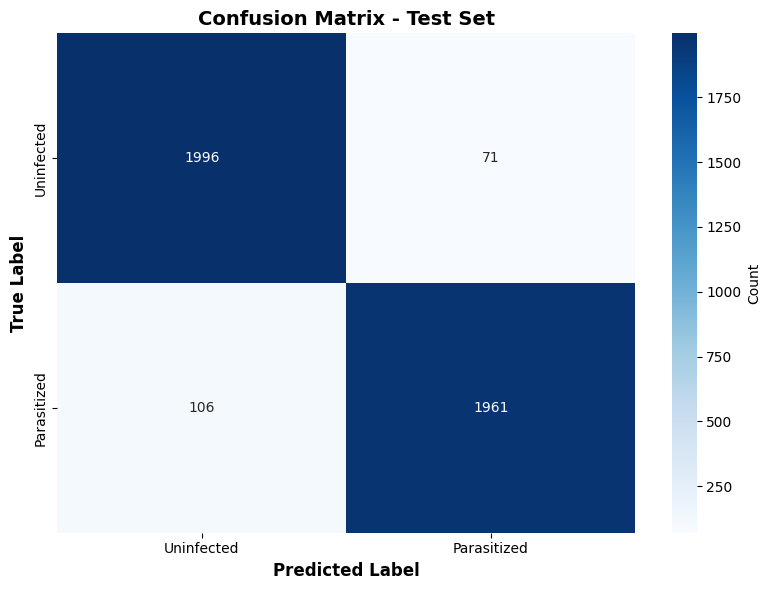


Confusion Matrix Breakdown:
  • True Negatives (TN):  1,996 (Correctly identified uninfected)
  • False Positives (FP): 71 (Uninfected misclassified as infected)
  • False Negatives (FN): 106 (Infected misclassified as uninfected)
  • True Positives (TP):  1,961 (Correctly identified infected)

Sensitivity (Recall): 94.87% (catching actual infections)
Specificity: 96.57% (correctly identifying healthy cells)


In [29]:
# ==============================================================================
# CONFUSION MATRIX VISUALIZATION
# ==============================================================================

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Uninfected', 'Parasitized'],
    yticklabels=['Uninfected', 'Parasitized'],
    cbar_kws={'label': 'Count'},
    ax=ax
)
ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax.set_title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Calculate percentages
tn, fp, fn, tp = cm.ravel()
print("\nConfusion Matrix Breakdown:")
print(f"  • True Negatives (TN):  {tn:,} (Correctly identified uninfected)")
print(f"  • False Positives (FP): {fp:,} (Uninfected misclassified as infected)")
print(f"  • False Negatives (FN): {fn:,} (Infected misclassified as uninfected)")
print(f"  • True Positives (TP):  {tp:,} (Correctly identified infected)")
print(f"\nSensitivity (Recall): {tp/(tp+fn)*100:.2f}% (catching actual infections)")
print(f"Specificity: {tn/(tn+fp)*100:.2f}% (correctly identifying healthy cells)")

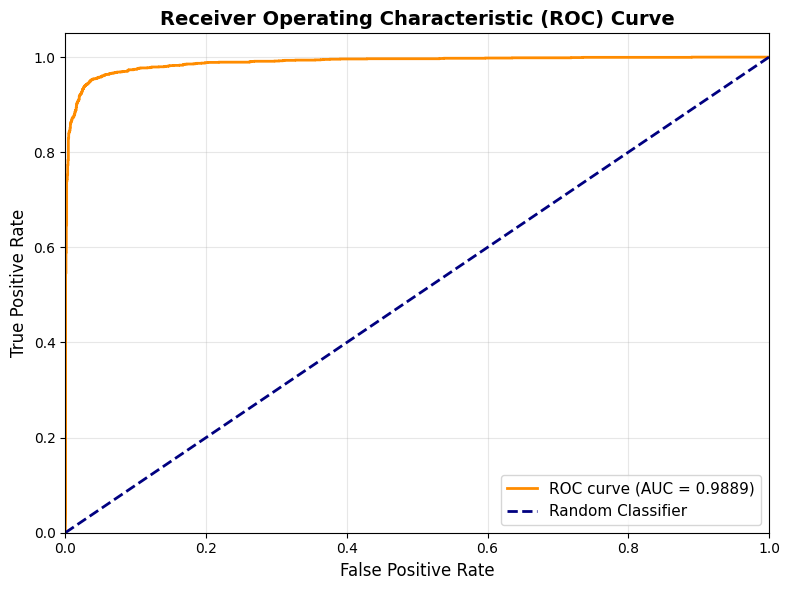


✓ AUC-ROC Score: 0.9889
  (1.0 = Perfect classifier, 0.5 = Random guessing)


In [30]:
# ==============================================================================
# ROC CURVE
# ==============================================================================

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = roc_auc_score(y_test, y_pred_probs)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
ax.legend(loc="lower right", fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ AUC-ROC Score: {roc_auc:.4f}")
print("  (1.0 = Perfect classifier, 0.5 = Random guessing)")

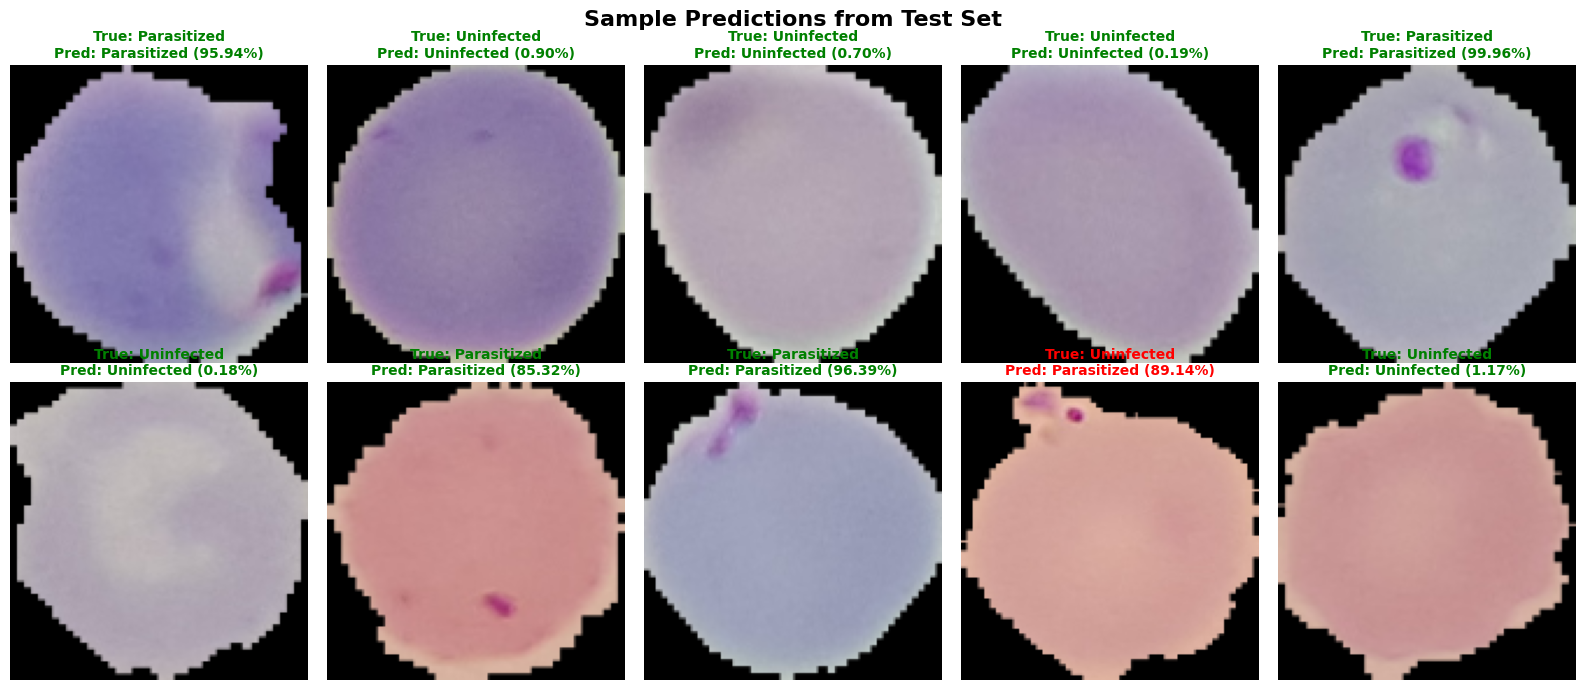


✓ Green border = Correct prediction
✓ Red border = Incorrect prediction


In [31]:
# ==============================================================================
# VISUALIZE SAMPLE PREDICTIONS
# ==============================================================================

# Get a batch from test set
test_images, test_labels = next(iter(test_dataset))
predictions = model.predict(test_images, verbose=0)

# Show 10 random samples
indices = np.random.choice(len(test_images), 10, replace=False)

fig, axes = plt.subplots(2, 5, figsize=(16, 7))
fig.suptitle('Sample Predictions from Test Set', fontsize=16, fontweight='bold')

for idx, ax in zip(indices, axes.flatten()):
    img = test_images[idx].numpy()
    true_label = test_labels[idx].numpy()
    pred_prob = predictions[idx][0]
    pred_label = 1 if pred_prob > 0.5 else 0

    # Determine if prediction is correct
    correct = (pred_label == true_label)
    color = 'green' if correct else 'red'

    # Labels
    true_class = 'Parasitized' if true_label == 1 else 'Uninfected'
    pred_class = 'Parasitized' if pred_label == 1 else 'Uninfected'

    # Plot
    ax.imshow(img)
    ax.set_title(
        f'True: {true_class}\nPred: {pred_class} ({pred_prob:.2%})',
        fontsize=10,
        color=color,
        fontweight='bold'
    )
    ax.axis('off')

plt.tight_layout()
plt.show()

print("\n✓ Green border = Correct prediction")
print("✓ Red border = Incorrect prediction")